Here I have made LLM model using GPT from scratch with constitution of Nepal.
All the works and references that I have done is taken from **Sebastian Raschka** book named  Build A Large Language Model (From Scratch).

In [2]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:0000:01


In [3]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.1.2
tiktoken version: 0.7.0


In [4]:
import urllib

# URL of the PDF file
url = "https://ag.gov.np/files/Constitution-of-Nepal_2072_Eng_www.moljpa.gov_.npDate-72_11_16.pdf"

# Open the URL and download the PDF
response = urllib.request.urlopen(url)
pdf_data = response.read()

# Save the PDF to a local file
with open("Constitution-of-Nepal_2072_Eng.pdf", "wb") as f:
    f.write(pdf_data)

print("PDF downloaded and saved as 'Constitution-of-Nepal_2072_Eng.pdf'")


PDF downloaded and saved as 'Constitution-of-Nepal_2072_Eng.pdf'


In [5]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.1 MB/s eta 0:00:00a 0:00:01


In [6]:
import PyPDF2

# Open the downloaded PDF file
with open("Constitution-of-Nepal_2072_Eng.pdf", "rb") as file:
    # Initialize a PDF reader object
    pdf_reader = PyPDF2.PdfReader(file)
    
    # Extract text from each page of the PDF
    raw_text = ""
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        raw_text += page.extract_text()

# Print the first 500 characters to preview the content
print(raw_text[:50])


 
1 
  
 
 
 
THE CONSTITUTION OF NEPAL  
   
2 
 


In [7]:
print(len(raw_text))

344782


**Split text into tokens**

In [8]:
import re
preprocessed = re.split(r'([,.:;?_!-"()\']|--|\s|[@#%&])', raw_text)

preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['1', 'THE', 'CONSTITUTION', 'OF', 'NEPAL', '2', 'Table', 'of', 'Content', 's', 'Preamble', 'Part-1', 'Preliminary', 'Part-2', 'Citizenship', 'Part-3', 'Fundamental', 'Rights', 'and', 'Duties', 'Part-4', 'Directive', 'Principles', ',', 'Policies', 'and', 'Obligations', 'of', 'the', 'State']


In [9]:
print(len(preprocessed))

65101


In [10]:
#Unique tokens
len(set(preprocessed))

4525

**Create a vocabulary**

In [11]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

4525


In [12]:
#Give indexes and put that as dictionary
vocab = {token:integer for integer,token in enumerate(all_words)}

# Simple Tokenization of text****

In [13]:
"""Putting all together"""

class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [14]:
tokenizer = SimpleTokenizerV1(vocab)
tokenizer.encode(""" """)


[]

# Using Bytepair Encoding 

In [15]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.7.0


In [16]:
tokenizer = tiktoken.get_encoding("gpt2")

In [17]:
text = (
    "No law shall be made providing for the death penalty to any one<|endoftext|> Every citizen"
     "of"
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[2949, 1099, 2236, 307, 925, 4955, 329, 262, 1918, 7389, 284, 597, 530, 50256, 3887, 9511, 1659]


In [18]:
tokenizer.encode("fddfsdfsf")

[69, 1860, 9501, 7568, 28202]

In [19]:
tokenizer.decode([1860])

'dd'

**Data Sampling with a sliding window**

**We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict**

In [20]:
import PyPDF2
# Open the downloaded PDF file
with open("Constitution-of-Nepal_2072_Eng.pdf", "rb") as file:
    # Initialize a PDF reader object
    pdf_reader = PyPDF2.PdfReader(file)
    
    # Extract text from each page of the PDF
    raw_text = ""
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        raw_text += page.extract_text()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

86531


In [21]:

vocab_size = len(set(enc_text))
print(vocab_size)

5305


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [23]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

**Test a dataloader with a batch size of 1 and context size of 4**

In [24]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[220, 198,  16, 220]]), tensor([[198,  16, 220, 198]])]


In [25]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[198,  16, 220, 198]]), tensor([[ 16, 220, 198, 220]])]


In [26]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[  220,   198,    16,   220],
        [  198,   220,   220,   198],
        [  220,   198,   220,   198],
        [  220,   198, 10970,  7102],
        [ 2257,  2043, 35354,  3963],
        [  399,  8905,  1847,   220],
        [  220,   198,   220,   220],
        [  220,   198,    17,   220]])

Targets:
 tensor([[  198,    16,   220,   198],
        [  220,   220,   198,   220],
        [  198,   220,   198,   220],
        [  198, 10970,  7102,  2257],
        [ 2043, 35354,  3963,   399],
        [ 8905,  1847,   220,   220],
        [  198,   220,   220,   220],
        [  198,    17,   220,   198]])


**Create token embeddings**

# Coding an LLM Architecture

In [27]:
GPT_CONFIG_124M = {
    "vocab_size": 5305,    # Vocabulary size from BPE
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True       # Query-Key-Value bias
}

**Coding the GPT Model**

In [28]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

In [29]:
print(inputs)

tensor([[  220,   198,    16,   220],
        [  198,   220,   220,   198],
        [  220,   198,   220,   198],
        [  220,   198, 10970,  7102],
        [ 2257,  2043, 35354,  3963],
        [  399,  8905,  1847,   220],
        [  220,   198,   220,   220],
        [  220,   198,    17,   220]])


In [30]:
import torch
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        # Ensure the input tensor is in float32 format
        if x.dtype != torch.float32:
            x = x.float()

        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec
torch.manual_seed(123)
# Create the SelfAttention_v1 instance
sa_v1 = SelfAttention_v1(d_in, d_out)
# Forward pass
print(sa_v1(inputs))


tensor([[33748.7266, 28081.3125],
        [33748.7266, 28081.3125],
        [33748.7266, 28081.3125],
        [33748.7266, 28081.3125],
        [33748.7266, 28081.3125],
        [33748.7266, 28081.3125],
        [33748.7266, 28081.3125],
        [33748.7266, 28081.3125]], grad_fn=<MmBackward0>)


In [31]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        if x.dtype != torch.float32:
            x = x.float()

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-1047.0566, -1945.5106],
        [-1047.0566, -1945.5106],
        [-1047.0566, -1945.5106],
        [-1047.0566, -1945.5106],
        [-1047.0566, -1945.5106],
        [-1047.0566, -1945.5106],
        [-1047.0566, -1945.5106],
        [-1047.0566, -1945.5106]], grad_fn=<MmBackward0>)


In [32]:
print(type(sa_v2.W_query))

<class 'torch.nn.modules.linear.Linear'>


**Applying a causal attention mask**

In [33]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience
inputs = inputs.to(torch.float32)  # Ensure inputs are float32

queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]], grad_fn=<SoftmaxBackward0>)


In [34]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])


In [35]:
print(attn_weights)

tensor([[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]], grad_fn=<SoftmaxBackward0>)


In [36]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]], grad_fn=<MulBackward0>)


In [37]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]], grad_fn=<DivBackward0>)


In [38]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[-2.1879e+04,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [-1.3480e+04, -1.7075e+04,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [-1.3992e+04, -1.7244e+04, -1.7778e+04,        -inf,        -inf,
                -inf,        -inf,        -inf],
        [ 2.9824e+04, -1.6149e+05, -1.5310e+05, -2.0735e+07,        -inf,
                -inf,        -inf,        -inf],
        [ 8.8224e+05, -2.4332e+05, -1.6096e+05, -7.7824e+07, -1.8636e+08,
                -inf,        -inf,        -inf],
        [-1.1653e+05, -2.6474e+05, -2.6475e+05, -2.4790e+07, -3.8156e+07,
          5.6874e+06,        -inf,        -inf],
        [-1.5006e+04, -1.7674e+04, -1.8277e+04, -1.2530e+06, -1.4423e+06,
          3.6030e+05, -2.1175e+04,        -inf],
        [-2.1845e+04, -1.7500e+04, -1.8679e+04, -8.5196e+05, -3.5977e+05,
          3.3800e+05, -2.1408e+04, -2.1843e+04]],
       grad_fn=

In [39]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]], grad_fn=<SoftmaxBackward0>)


**Masking additional attention weights with dropout**

In [40]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [41]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0.]], grad_fn=<MulBackward0>)


**Now, we are ready to implement a working implementation of self-attention, including the causal and dropout masks**

In [42]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 8 tokens each, and each token has embedding dimension 4

torch.Size([2, 8, 4])


In [43]:
"""Causal attention means that the model cannot look at the future,
but can take a look back"""
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[ 1.4331e+01,  2.0460e+02],
         [ 2.3399e+00,  2.1614e+02],
         [-1.3254e+01,  2.2187e+02],
         [-1.7280e+02,  5.0237e+03],
         [-3.7248e+03,  7.7348e+03],
         [ 1.4331e+01,  2.0460e+02],
         [-3.7248e+03,  7.7348e+03],
         [-3.7248e+03,  7.7348e+03]],

        [[ 1.4331e+01,  2.0460e+02],
         [ 2.3399e+00,  2.1614e+02],
         [-1.3254e+01,  2.2187e+02],
         [-1.7280e+02,  5.0237e+03],
         [-3.7248e+03,  7.7348e+03],
         [ 1.4331e+01,  2.0460e+02],
         [-3.7248e+03,  7.7348e+03],
         [-3.7248e+03,  7.7348e+03]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 8, 2])


# Extending single-head attention to multi-head attention
**Stacking multiple single-head attention layers**

In [44]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape  # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # Example of attention mechanism (scaled dot-product attention)
        attention_scores = torch.bmm(queries, keys.transpose(1, 2)) / (d_in ** 0.5)
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        attended_values = torch.bmm(attention_weights, values)
        
        return attended_values  # Output dimension: (b, num_tokens, d_out)

class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, dropout, qkv_bias) for _ in range(num_heads)]
        )
    
    def forward(self, x):
        # Apply each attention head and concatenate the results
        head_outputs = [head(x) for head in self.heads]
        concat_output = torch.cat(head_outputs, dim=-1)  # Concatenate along the feature dimension
        return concat_output

# Example usage
torch.manual_seed(123)

batch = torch.randn(16, 10, 3)  # Example batch with shape (batch_size, context_length, d_in)
context_length = batch.shape[1]
d_in, d_out = 3, 2
num_heads = 2

mha = MultiHeadAttentionWrapper(
    d_in, d_out, dropout=0.0, num_heads=num_heads
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


tensor([[[ 3.4373e-02,  3.4932e-02, -1.8032e-02,  2.7194e-02],
         [ 5.6516e-02,  1.2576e-02, -1.2246e-02, -2.2201e-03],
         [ 4.3832e-02,  2.4913e-02, -8.2159e-03, -2.6836e-02],
         [ 7.0120e-02,  3.9669e-02, -3.9439e-02,  1.1509e-01],
         [ 5.6048e-02, -2.2458e-02, -2.1695e-02,  4.5938e-02],
         [ 3.6287e-02,  4.3885e-02, -2.6986e-02,  6.6795e-02],
         [ 5.5130e-02, -1.7051e-02, -7.5909e-03, -3.0422e-02],
         [ 2.8773e-02, -1.8578e-03, -2.5042e-02,  6.0119e-02],
         [ 2.1483e-02,  4.3345e-02, -3.3426e-03, -6.4934e-02],
         [ 5.6056e-02,  5.0708e-02, -8.6930e-03, -2.4235e-02]],

        [[-4.1947e-02,  9.0336e-02,  1.0794e-01, -1.5351e-01],
         [-1.2100e-01, -3.1050e-04,  1.4609e-01, -2.9761e-01],
         [-8.7553e-02,  6.6382e-03,  1.0577e-01, -1.3918e-01],
         [-6.8727e-02, -7.0204e-02,  1.2272e-01, -2.1260e-01],
         [-1.3041e-01, -3.2071e-02,  1.0984e-01, -1.5795e-01],
         [-9.9118e-02, -2.5848e-02,  9.6548e-02, -8.3

# Implementing multi-head attention with weight splits

In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[ 0.1829,  0.6533],
         [ 0.2044,  0.6853],
         [ 0.2343,  0.7194],
         [ 0.0991,  0.7718],
         [ 0.1481,  0.6130],
         [ 0.1328,  0.6741],
         [ 0.1988,  0.5684],
         [ 0.1820,  0.5086],
         [ 0.2775,  0.5498],
         [ 0.2107,  0.6883]],

        [[ 0.1155,  1.5834],
         [ 0.3182,  1.2603],
         [ 0.2205,  1.2699],
         [ 0.2575,  1.0431],
         [ 0.2662,  0.9379],
         [ 0.1915,  0.9777],
         [ 0.1005,  0.8624],
         [ 0.3509,  0.7102],
         [ 0.3911,  0.5504],
         [ 0.2749,  0.7494]],

        [[ 0.2119,  1.0297],
         [ 0.2763,  0.6831],
         [ 0.2420,  0.8347],
         [ 0.4347,  0.7683],
         [ 0.2326,  0.7210],
         [ 0.2635,  0.7271],
         [ 0.3182,  0.7598],
         [ 0.2509,  0.7100],
         [ 0.2235,  0.7215],
         [ 0.1617,  0.9823]],

        [[ 0.2018,  0.6495],
         [ 0.0435,  0.7165],
         [-0.1398,  1.4743],
         [ 0.0688,  0.8622],
        

# Pretraining LLMs

In [46]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.7.5
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.1.2
tensorflow version: 2.15.0


# GPT Model

In [47]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [48]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [49]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

# Using GPT to generate text

In [50]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


**Calculating the text generation loss: cross-entropy and perplexity**

In [51]:
# First 100 characters
print(raw_text[:99])

 
1 
  
 
 
 
THE CONSTITUTION OF NEPAL  
   
2 
 Table of Content s 
 
Preamble   
Part-1  
Prelim


In [52]:
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 344782
Tokens: 86531


**Divide the dataset into a training and a validation set and use the data loaders to prepare the batches for LLM training**

In [53]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [54]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [55]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [56]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

**Another optional check that the token sizes are in the expected ballpark**


In [57]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 76800
Validation tokens: 9216
All tokens: 86016


**we implement a utility function to calculate the cross-entropy loss of a given batch
In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader**

In [58]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.945489864349366
Validation loss: 10.951971689860025


# Training an LLM

In [60]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

Now, let's train the LLM using the training function defined above:


In [61]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Sovereign People of Nepal", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 8.985, Val loss 8.989
Ep 1 (Step 000005): Train loss 7.356, Val loss 7.408
Ep 1 (Step 000010): Train loss 6.463, Val loss 6.489
Ep 1 (Step 000015): Train loss 5.937, Val loss 5.992
Ep 1 (Step 000020): Train loss 5.660, Val loss 5.729
Ep 1 (Step 000025): Train loss 5.460, Val loss 5.630
Ep 1 (Step 000030): Train loss 5.629, Val loss 5.407
Ep 1 (Step 000035): Train loss 5.260, Val loss 5.303
Ep 1 (Step 000040): Train loss 5.359, Val loss 5.271
Ep 1 (Step 000045): Train loss 4.921, Val loss 5.005
Ep 1 (Step 000050): Train loss 5.293, Val loss 4.927
Ep 1 (Step 000055): Train loss 5.009, Val loss 4.907
Ep 1 (Step 000060): Train loss 4.865, Val loss 4.977
Ep 1 (Step 000065): Train loss 5.139, Val loss 4.817
Ep 1 (Step 000070): Train loss 4.916, Val loss 4.770
Ep 1 (Step 000075): Train loss 4.796, Val loss 4.725
Ep 1 (Step 000080): Train loss 4.290, Val loss 4.640
Ep 1 (Step 000085): Train loss 4.579, Val loss 4.568
Ep 1 (Step 000090): Train loss 4.273, Val loss

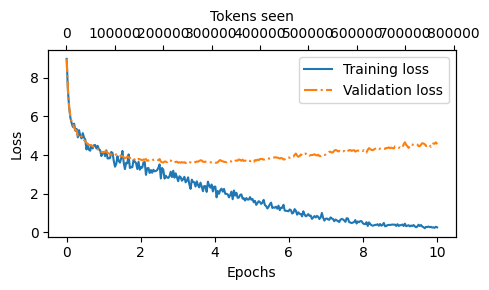

In [62]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [63]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Sovereign People of Nepal", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Sovereign People of Nepal or a 
147 
authority, inhuman or degrading 
(2) The committee under clause (3)


**Modifying the text generation function**

In [68]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [70]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Sovereign People of Nepal", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Sovereign People of Nepal 
formed in the offices in the Federal  
between the country


#  Loading and saving model weights in PyTorch

In [ ]:
#torch.save(model.state_dict(), "model.pth")
